# Model building

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import plot_roc_curve, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras import backend as K
#from tensorflow.keras.layers.embeddings import Embedding

import datetime

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_orig = pd.read_csv("df_processed.csv")
df_orig.replace(np.nan, "no_text", inplace=True)

In [4]:
print ( df_orig.shape, df_orig.columns)
df_orig.head(2)

(541438, 21) Index(['Unnamed: 0', 'id', 'subreddit', 'title', 'author', 'url', 'created',
       'ext_link', 'id.1', 'body', 'score', 'upvote_ratio', 'body_processed',
       'title_processed', 'author_processed', 'subreddit_processed',
       'body_and_title', 'body_and_author', 'title_and_author',
       'body_title_and_author', 'body_title_author_subreddit'],
      dtype='object')


,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,upvote_ratio,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit
0,0,koaw8g,finance,Tech's top seven companies added $3.4 trillion...,Obrocheetah,https://www.reddit.com/r/finance/comments/koaw...,1609505868,no_text,koaw8g,[deleted],...,1.0,deleted,top seven companies added trillion value,obrocheetah,finance,deleted top seven companies added trillion value,deleted obrocheetah,top seven companies added trillion value obroc...,deleted top seven companies added trillion val...,deleted top seven companies added trillion val...
1,1,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,no_text,...,1.0,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,finance,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...,no_text mogo establishes atm equity program mo...


In [5]:
# delete the rows with empty body
df = df_orig[(df_orig.body_processed != 'deleted') & (df_orig.body_processed != 'removed')]
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,upvote_ratio,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit
1,1,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,no_text,...,1.0,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,finance,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...,no_text mogo establishes atm equity program mo...
3,3,koe39g,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.reddit.com/r/finance/comments/koe3...,1609518689,https://www.fintechinshorts.com/standard-capit...,koe39g,no_text,...,1.0,no_text,standard capital partners solidblock standard ...,fintechinshorts,finance,no_text standard capital partners solidblock s...,no_text fintechinshorts,standard capital partners solidblock standard ...,no_text standard capital partners solidblock s...,no_text standard capital partners solidblock s...


## Popular as 95 percentile

In [7]:
df_superstocks = df[df.subreddit == 'Superstonks']
df_finance     = df[df.subreddit == 'finance']
df_options     = df[df.subreddit == 'options']
df_pennystocks = df[df.subreddit == 'pennystocks']
df_gme         = df[df.subreddit == 'GME']

In [8]:
df_superstocks['popular'] = 0
df_finance['popular'] = 0
df_options['popular'] = 0
df_pennystocks['popular'] = 0
df_gme['popular'] = 0

In [9]:
df_superstocks.loc[df_superstocks['score'] > np.percentile(df_superstocks.score.values, 95), 'popular'] = 1
df_finance.loc[df_finance['score'] > np.percentile(df_finance.score.values, 95), 'popular'] = 1
df_options.loc[df_options['score'] > np.percentile(df_options.score.values, 95), 'popular'] = 1
df_pennystocks.loc[df_pennystocks['score'] > np.percentile(df_pennystocks.score.values, 95), 'popular'] = 1
df_gme.loc[df_gme['score'] > np.percentile(df_gme.score.values, 95), 'popular'] = 1

In [10]:
df = pd.concat([df_superstocks, df_finance, df_options,
                df_pennystocks, df_gme], ignore_index=True)

In [11]:
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit,popular
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,r superstonk,sub looking r superstonk,seppukkake,superstonks,r superstonk sub looking r superstonk,r superstonk seppukkake,sub looking r superstonk seppukkake,r superstonk sub looking r superstonk seppukkake,r superstonk sub looking r superstonk seppukka...,1
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,no_text,https www reddit com r superstonk,fairytalee,superstonks,no_text https www reddit com r superstonk,no_text fairytalee,https www reddit com r superstonk fairytalee,no_text https www reddit com r superstonk fair...,no_text https www reddit com r superstonk fair...,0


In [12]:
df.columns

Index(['Unnamed: 0', 'id', 'subreddit', 'title', 'author', 'url', 'created',
       'ext_link', 'id.1', 'body', 'score', 'upvote_ratio', 'body_processed',
       'title_processed', 'author_processed', 'subreddit_processed',
       'body_and_title', 'body_and_author', 'title_and_author',
       'body_title_and_author', 'body_title_author_subreddit', 'popular'],
      dtype='object')

In [13]:
import string, re, datetime

def emoji_count(s):
    s = ''.join(word.strip(string.punctuation) for word in s.split())
    return len(re.findall('[^\w\s,\(\)\'\/-]',s))

def hourOfDay(utc):
    return datetime.datetime.utcfromtimestamp(utc).hour

def dayOfWeek(utc):
    return datetime.datetime.utcfromtimestamp(utc).weekday()

def textLength(text):
    return len(text.split())

def postType(link):
    if not link:
        return 'others'
    if 'png' in link or 'jpg' in link:
        return 'figures'
    elif '/r/' in link:
        return 'others'
    else:
        return 'outside_link'

def countUpper(text):
    Up = 0
    Low = 0
    for ch in text:
        if ch.isupper():
            Up += 1
        elif ch.islower():
            Low += 1
    
    if Up + Low:
        return Up/(Up+Low)
    else:
        return 0
    
def exclamationAndQuestion(text):
    return text.count('!') + text.count('?')

def getMonth(utc):
    return datetime.datetime.utcfromtimestamp(utc).month
    
def primeTime(hour):
    primeTime = 1 if hour >= 7 and hour <= 11 else 0
    return primeTime

def weekend(day):
    return 1 if day >= 5 else 0

In [14]:
df['title_emoji'] = df['title'].apply(emoji_count)
df['body_emoji'] = df['body'].apply(emoji_count)
df['title_length'] = df['title'].apply(textLength)
df['body_length'] = df['body'].apply(textLength)
df['title_EQ'] = df['title'].apply(exclamationAndQuestion)
df['body_EQ'] = df['body'].apply(exclamationAndQuestion)
#df['title_UL'] = df['title'].apply(countUpper)
#df['body_UL'] = df['body'].apply(countUpper)    
df['hour'] = df['created'].apply(hourOfDay)
df['day'] = df['created'].apply(dayOfWeek)
#df['post_type'] = df['ext_link'].apply(postType)
df['prime_time'] = df['hour'].apply(primeTime)
df['weekend'] = df['day'].apply(weekend)
df['month'] = df['created'].apply(getMonth)

In [15]:
from num2words import num2words

def get_num2words(num):
    w = num2words(num)
    w = re.sub(' ', '_', w)
    w = re.sub('-', '_', w)
    return w

def convert_nums(nums):
    return " ".join([get_num2words(num) for num in nums])

convert_nums([0, 12, 44, 123])

'zero twelve forty_four one_hundred_and_twenty_three'

In [16]:
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,body_emoji,title_length,body_length,title_EQ,body_EQ,hour,day,prime_time,weekend,month
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,0,8,1,0,0,9,0,1,0,4
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,0,1,1,0,0,10,0,1,0,4


In [17]:
cols = ['title_emoji', 'body_emoji', 'title_length',
        'body_length','title_EQ','body_EQ', 'hour',
        'day', 'prime_time', 'weekend', 'month']

df['feats_joined_w'] = df[cols].apply(convert_nums, axis=1)
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,title_length,body_length,title_EQ,body_EQ,hour,day,prime_time,weekend,month,feats_joined_w
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,8,1,0,0,9,0,1,0,4,zero zero eight one zero zero nine zero one ze...
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,1,1,0,0,10,0,1,0,4,three zero one one zero zero ten zero one zero...


In [18]:
df['join1'] = df['subreddit'].str.lower() + ' ' + df['body_title_and_author']
df['join2'] = df['join1'] + ' '+ df['feats_joined_w']
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,title_EQ,body_EQ,hour,day,prime_time,weekend,month,feats_joined_w,join1,join2
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,0,0,9,0,1,0,4,zero zero eight one zero zero nine zero one ze...,superstonks r superstonk sub looking r superst...,superstonks r superstonk sub looking r superst...
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,0,0,10,0,1,0,4,three zero one one zero zero ten zero one zero...,superstonks no_text https www reddit com r sup...,superstonks no_text https www reddit com r sup...


## Split data by data

In [19]:
df['posting_time'] = df['created'].apply(datetime.datetime.fromtimestamp)
df['posting_month'] = df['posting_time'].apply(lambda dd: dd.month)
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,hour,day,prime_time,weekend,month,feats_joined_w,join1,join2,posting_time,posting_month
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,9,0,1,0,4,zero zero eight one zero zero nine zero one ze...,superstonks r superstonk sub looking r superst...,superstonks r superstonk sub looking r superst...,2021-04-05 05:00:28,4
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,10,0,1,0,4,three zero one one zero zero ten zero one zero...,superstonks no_text https www reddit com r sup...,superstonks no_text https www reddit com r sup...,2021-04-05 06:42:35,4


In [20]:
df = df[["posting_month", "join1", "join2", "popular"]]

In [21]:
df_train = df[df['posting_month']<4]
df_test  = df[df['posting_month']==4]

In [22]:
print (f"Training Shape: {df_train.shape[0]},  Test shape: {df_test.shape[0]}")

Training Shape: 99226,  Test shape: 27072


In [23]:
df_train.head(2)

,posting_month,join1,join2,popular
120,1,finance no_text mogo establishes atm equity pr...,finance no_text mogo establishes atm equity pr...,0
121,1,finance no_text standard capital partners soli...,finance no_text standard capital partners soli...,0


In [24]:
def check_distribution(df, ycol='popular'):
    labels = df.groupby(ycol).count().iloc[:2,0].values
    print (labels, np.round(100*labels/sum(labels), 2))

In [25]:
check_distribution(df)

[126282   6640] [95.  5.]


In [26]:
check_distribution(df_train)

[94780  4446] [95.52  4.48]


In [27]:
check_distribution(df_test)

[25230  1842] [93.2  6.8]


## Convert text to vector

In [28]:
xcol = 'join2'
ycol = 'popular'

In [ ]:
# MAX_WORDS   = 1000
# tokenizer = Tokenizer(num_words=MAX_WORDS)
# tokenizer.fit_on_texts(df_train[xcol])
# X_train = tokenizer.texts_to_matrix(df_train[xcol])
# X_test  = tokenizer.texts_to_matrix(df_test[xcol])

In [92]:
# y_train = df_train[ycol]
# y_test  = df_test[ycol]

In [37]:
from gensim.models import Word2Vec

In [38]:
from gensim.test.utils import common_texts
model = Word2Vec(sentences = common_texts,
                     vector_size=10,
                     window=1, 
                     min_count=1)

In [39]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [40]:
model.wv.key_to_index

{'system': 0,
 'graph': 1,
 'trees': 2,
 'user': 3,
 'minors': 4,
 'eps': 5,
 'time': 6,
 'response': 7,
 'survey': 8,
 'computer': 9,
 'interface': 10,
 'human': 11}

In [41]:
# Now we'll calculate representations for our documents
doc_embedding = np.zeros((len(common_texts),10))

for i in range(len(common_texts)):
    for word in common_texts[i]:
        doc_embedding[i,:] = doc_embedding[i,:] + model.wv[word]/len(common_texts[i])

In [42]:
doc_embedding 

array([[-0.02466105, -0.01504427,  0.01021254,  0.04354756,  0.06812997,
         0.02039656, -0.00337396,  0.02178648, -0.01909228, -0.00114108],
       [-0.0056582 ,  0.01831707,  0.02987248, -0.01321817, -0.00809442,
         0.0015124 ,  0.03043401, -0.00679826, -0.02092893, -0.00303141],
       [-0.06206357,  0.01866995,  0.03923655,  0.02064063,  0.01082371,
        -0.04921004,  0.05039736,  0.0057547 , -0.02839702, -0.01322939],
       [-0.02410149, -0.00850073,  0.00117402,  0.06486905, -0.01688685,
        -0.02867532,  0.06058872,  0.04672439, -0.04342125,  0.00327489],
       [-0.01211206,  0.02579124,  0.01314868, -0.08070244,  0.00176653,
         0.00368167,  0.04876873, -0.00403882, -0.01778741, -0.03748705],
       [ 0.07311766,  0.05070262,  0.06757693,  0.00762866,  0.06350889,
        -0.03405366, -0.00946403,  0.05768573, -0.07521639, -0.03936105],
       [ 0.07346135,  0.01768395,  0.01110539,  0.03658458,  0.00745364,
        -0.02610692,  0.00965089,  0.03380224

In [43]:
dfs = df.copy().sample(5000)

In [44]:
print ( dfs.shape )
dfs.head(2)

(5000, 4)


,posting_month,join1,join2,popular
103007,3,gme no_text good bot herrfolgreich,gme no_text good bot herrfolgreich one zero th...,0
9809,4,options no_text major difference contracts mak...,options no_text major difference contracts mak...,0


In [45]:
xcol = 'join2'
ycol = 'popular'

In [46]:
from gensim.models import Word2Vec

In [47]:
#max(len(s.split)
max([len(s.split()) for s in dfs[xcol].values])

2976

In [48]:
model = Word2Vec(sentences = dfs[xcol].values,
                 vector_size=1000,
                 window=5, 
                 min_count=5)

In [49]:
dfs.shape

(5000, 4)

In [ ]:
# Now we'll calculate representations for our documents
doc_embedding = np.zeros((dfs.shape[0], 1000))

for i in range(dfs.shape[0]):
    for word in dfs[xcol].values[i]:
        doc_embedding[i,:] = doc_embedding[i,:] + model.wv[word]/len(common_texts[i])

In [54]:
len(dfs[xcol].values[ii])

363

In [58]:
doc_embedding = np.zeros((dfs.shape[0], 1000))

for i in range(dfs.shape[0]):    
    for w in dfs[xcol].values[i]:
        dd = model.wv[w]/dfs.shape[0]
        doc_embedding[i,:] = doc_embedding[i,:] + dd
print (doc_embedding.shape)

(5000, 1000)


In [59]:
doc_embedding[12]

array([ 4.88314822e-03,  2.13508764e-04,  3.22432449e-03,  4.74439269e-03,
        1.20454345e-03,  2.36972943e-03, -2.15556575e-03, -9.58131658e-04,
       -2.63303197e-03,  1.17626465e-03, -1.97666783e-04, -4.34063837e-03,
       -2.69609265e-03,  2.18621433e-03,  3.74069809e-03,  4.77372602e-03,
        1.85622595e-03,  3.21130560e-03,  4.96500622e-04,  7.43910501e-04,
        6.49321405e-04,  6.84775473e-04, -6.49831772e-04,  1.63448331e-03,
       -3.35891356e-03, -5.44886225e-05,  3.67296605e-04, -1.16905263e-03,
       -1.06073254e-03,  4.35026758e-04, -1.35343670e-03, -7.24015128e-04,
       -1.15132347e-03,  3.04477693e-03,  1.77225647e-03,  4.01269660e-04,
        6.59990882e-04, -1.13402149e-03, -1.04573051e-03, -5.70056216e-04,
        2.47196268e-03, -2.43866841e-03,  1.08389987e-03,  1.16783833e-03,
       -5.68421416e-04,  2.96085160e-03,  8.16255638e-04, -2.31088179e-03,
       -7.45136201e-04, -2.56346729e-03, -1.21147929e-03,  2.46562036e-03,
        1.47309496e-03, -

In [61]:
dfs[ycol].values

array([0, 0, 0, ..., 0, 1, 1])

In [63]:
model = LogisticRegression()
model.fit(doc_embedding, dfs[ycol].values)

LogisticRegression()

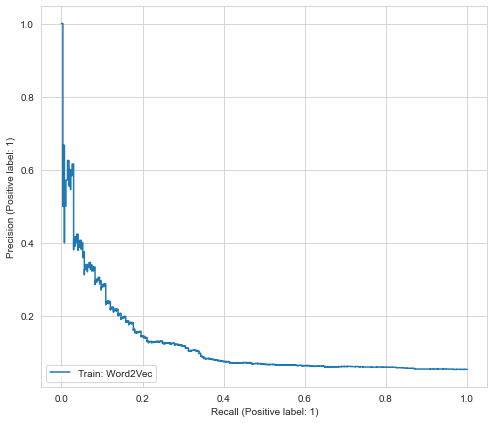

In [64]:
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(1,1, figsize=(8,7))
plot_precision_recall_curve(model, doc_embedding, dfs[ycol].values, ax=ax, label="Train: Word2Vec")

In [67]:
vector_size = 5000
model2 = Word2Vec(sentences = dfs[xcol].values,
                 vector_size=vector_size,
                 window=5, 
                 min_count=10)

In [68]:
def get_X(model, df, xcol, vector_size):
    X = np.zeros((df.shape[0], vector_size))
    for i in range(df.shape[0]):    
        for w in df[xcol].values[i]:
            X[i,:] = X[i,:] + model.wv[w]/df.shape[0]
    return X

In [69]:
X2 = get_X(model2, dfs, xcol, vector_size)

In [70]:
model_LR2 = LogisticRegression()
model_LR2.fit(X2, dfs[ycol].values)

LogisticRegression()

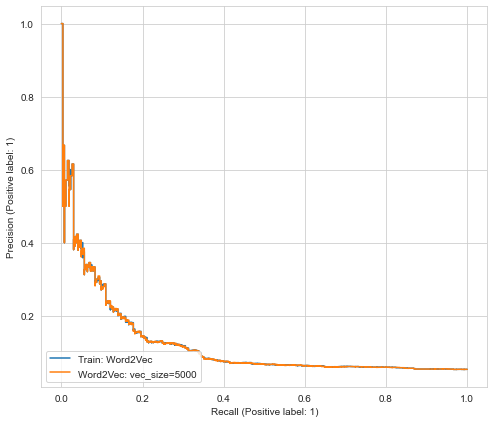

In [71]:
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(1,1, figsize=(8,7))
plot_precision_recall_curve(model, doc_embedding, dfs[ycol].values, ax=ax, label="Train: Word2Vec")
plot_precision_recall_curve(model_LR2, X2, dfs[ycol].values, ax=ax, label="Word2Vec: vec_size=5000")

In [72]:
def train_w2v_LR_model(df, xcol, ycol, vector_size = 5000):
    model_w2v = Word2Vec(sentences = df[xcol].values,
                         vector_size=vector_size,
                         window=5, 
                         min_count=10)
    
    X = np.zeros((df.shape[0], vector_size))
    for i in range(df.shape[0]):    
        for w in df[xcol].values[i]:
            X[i,:] = X[i,:] + model_w2v.wv[w]/df.shape[0]

    model_LR = LogisticRegression(max_iter=1000)
    model_LR.fit(X, df[ycol].values)
    return (model_LR, X, df[ycol], model_w2v)
    

In [73]:
xcol = 'join2'
ycol = 'popular'

In [ ]:
model1, X1, y1, model_w2v1 = train_w2v_LR_model(df, xcol, ycol, vector_size = 5000)